In [1]:
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from scipy import sparse
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import ngboost as ngb
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [12]:
# Evaluation Metrics
def evaluation_metric(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def nrmse(y_true, y_pred):
    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse_val / (y_true.max() - y_true.min())

def test_error_percentage(score, y_true):
    mean = y_true.mean()
    return (score/mean) * 100

def mae(y_true, y_pred):
    n = len(y_true)
    mae = sum(abs(y_true[i] - y_pred[i]) for i in range(n)) / n
    return mae

def test_rmse(y_true, y_pred):
    print(f"mae : {mae(y_true, y_pred)}")
    print(f"RMSE : {evaluation_metric(y_true, y_pred)}")
    print(f"Normalized RMSE : {nrmse(y_true, y_pred)}")
    score = evaluation_metric(y_true, y_pred)
    print(f"Error Percentage : {test_error_percentage(score, y_true)}")
    
def preprocess_data(test_num):
    
    all_data = pd.read_csv('asos_train.csv', encoding='cp949')

    all_data_train = all_data[all_data['location'] != test_num]
    all_data_test = all_data[all_data['location'] == test_num]



    all_data_train.fillna(-1, inplace=True)
    all_data_test.fillna(-1, inplace=True)

    all_data = pd.concat([all_data_train, all_data_test], ignore_index=True)

    all_data['date'] = pd.to_datetime(all_data['date'])

    # 연도, 월, 시간 추출하여 새로운 열로 추가
    all_data['year'] = all_data['date'].dt.year
    all_data['month'] = all_data['date'].dt.month
    all_data['hour'] = all_data['date'].dt.hour

# Index(['power', 'date', 'name', 'capacities', 'asos_num', 'land', 'power/land',
#        'location', 'Date/Time', 'Temp(C)', 'Prec(mm)', 'Wind_speed(m/s)',
#        'Wind_Direction(16 compass points)', 'Humidity', 'Vapor_pressure(hPa)',
#        'Dew_Point(C)', 'Local Atmospheric Pressure(hPa)',
#        'Sea-level_Pressure(hPa)', 'sunshine(hr)', 'Solar_Radiation(MJ/m2)',
#        'Snowfall(cm)', '3-hour_Fresh_Snowfall', 'Cloud_Cover(1/10)',
#        'Mid-Low_Cloud_Cover', 'Cloud_Form', 'Lowest_Cloud_Height(100m)',
#        'Visibility(10m)', 'Ground_Condition', 'Phenomenon_Number',
#        'Ground Temp', '5cm_Underground_Temp', '10cm_Underground_Temp',
#        '20cm_Underground_Temp', '30cm_Underground_Temp'],
#       dtype='object')

    drop_columns = ["date", "asos_num", "location", "name", "power/land", "power", "capacities", "land",
                   'Wind_Direction(16 compass points)', 'Humidity', 'Vapor_pressure(hPa)', "Date/Time",
                    'Local Atmospheric Pressure(hPa)',
                   'Sea-level_Pressure(hPa)', 
                   '3-hour_Fresh_Snowfall',
                   'Mid-Low_Cloud_Cover', 'Cloud_Form', 'Lowest_Cloud_Height(100m)',
                   'Visibility(10m)', 'Ground_Condition', 'Phenomenon_Number',
                   'Ground Temp', '5cm_Underground_Temp', '10cm_Underground_Temp',
                   '20cm_Underground_Temp', '30cm_Underground_Temp']

    all_data = all_data.drop(columns=drop_columns)

    all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data)], format='csr')
    num_train = len(all_data_train)
    X = all_data_sprs[:num_train]
    X_test = all_data_sprs[num_train:]
    y = all_data_train['power/land'].values
    y_test = all_data_test['power/land'].values
    return X, y, X_test, y_test

def calculate_pearsonr(data1, data2):
    return pearsonr(data1, data2)

def daily_visualize(y_test_array, preds, test_df):
    # 'date' 칼럼을 datetime 형식으로 변환하고 인덱스로 설정
    y_test_df = pd.DataFrame(y_test_array, index=pd.to_datetime(test_df['date']), columns=['power/land'])
    
    # 일자별로 그룹화하고 합계를 계산
    daily_actual_sum = y_test_df.groupby(y_test_df.index.date)['power/land'].sum().values
    daily_predicted_sum = [np.sum(preds[y_test_df.index.date == date]) for date in np.unique(y_test_df.index.date)]
    
    # 상관계수 계산
    corr_coefficient, p_value = calculate_pearsonr(daily_actual_sum, daily_predicted_sum)

    plt.figure(figsize=(15, 6))
    plt.plot(daily_actual_sum, label='Actual Daily Power Sum', color='blue')
    plt.plot(daily_predicted_sum, label='Predicted Daily Power Sum', color='red', alpha=0.7)
    plt.title('Daily Power Sum')
    plt.ylabel('Power Sum')
    plt.legend()
    plt.grid(True, axis='y')
    
    # 상관계수를 그래프 상에 주석으로 추가
    corr_text = f"Pearson correlation coefficient: {corr_coefficient:.6f}\nP-value: {p_value:.6f}"
    plt.annotate(corr_text, xy=(0.75, 0.15), xycoords='axes fraction', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="aliceblue"))

    plt.show()

In [13]:
def main(test_nums, model_choices):
    for test_num in test_nums:
        print(f"Testing for location {test_num}...")
        
        all_data = pd.read_csv('asos_train.csv', encoding='cp949')
        all_data_train = all_data[all_data['location'] != test_num]
        all_data_test = all_data[all_data['location'] == test_num]

        X, y, X_test, y_test = preprocess_data(test_num)

        for model_choice in model_choices:
            print(f"\tTraining and Predicting using {model_choice} model...")

            if model_choice == 'lgb': #lightgbm
                model = LGBMRegressor()
            elif model_choice == 'xgb': #xgboost
                model = XGBRegressor()
            elif model_choice == 'ext': #extratree
                model = ExtraTreesRegressor()
            elif model_choice == 'rf': #random forest
                model = RandomForestRegressor()
            elif model_choice == 'cbc': #catboost
                model = CatBoostRegressor()
            elif model_choice == 'ngb': #ngboost
                model = ngb.NGBRegressor()
            # For other models, you can add more elif conditions as needed.

            model.fit(X, y)
            predictions = model.predict(X_test)
            test_rmse(y_test, predictions)
            daily_visualize(y_test, predictions, all_data_test)

            print(f"\tCompleted {model_choice} model.")
        print(f"Completed testing for location {test_num}.\n\n")

Testing for location 165.0...


C:\Users\sedag\AppData\Local\Temp\ipykernel_25928\1367900956.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_train.fillna(-1, inplace=True)
C:\Users\sedag\AppData\Local\Temp\ipykernel_25928\1367900956.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_test.fillna(-1, inplace=True)


	Training and Predicting using lgb model...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1179
[LightGBM] [Info] Number of data points in the train set: 203914, number of used features: 11
[LightGBM] [Info] Start training from score 26.964930
mae : 10.864657361469071
RMSE : 16.614859421192303
Normalized RMSE : 0.235650007710037
Error Percentage : 71.84605512822337


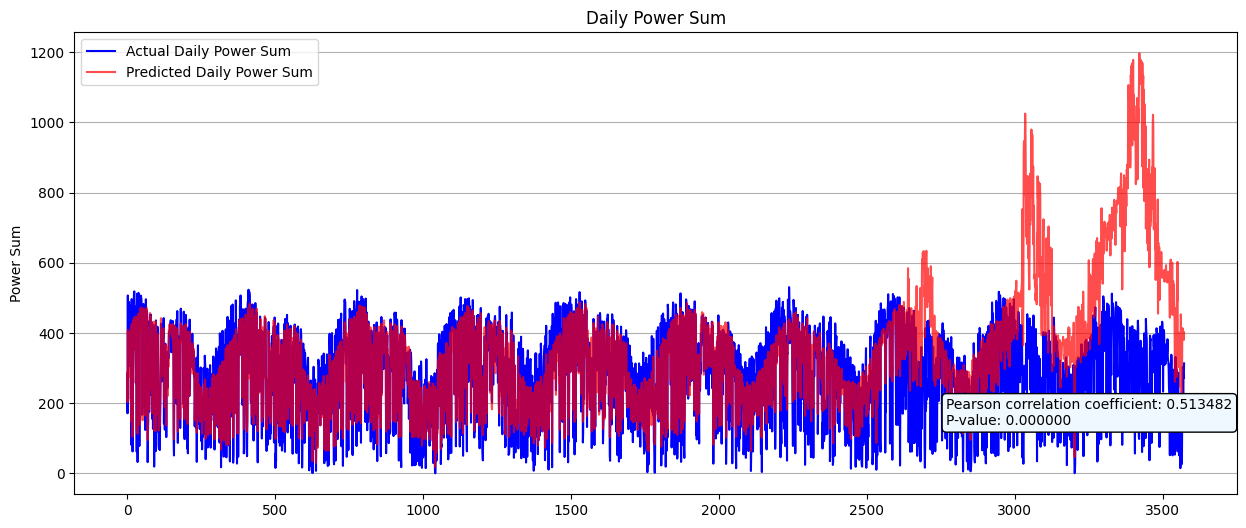

	Completed lgb model.
	Training and Predicting using xgb model...
mae : 11.848949269385685
RMSE : 18.975588948265603
Normalized RMSE : 0.2691324415455328
Error Percentage : 82.05433311874287


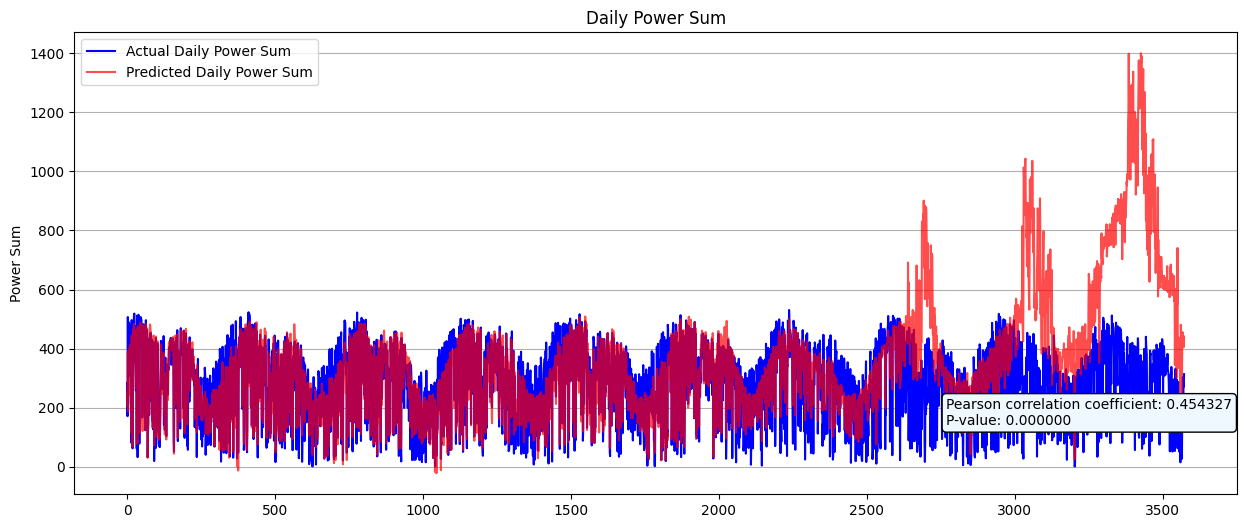

	Completed xgb model.
	Training and Predicting using ext model...


In [ ]:
#165.영암, 112.인천, 140.군산, 133.대전, 288.밀양, 239.세종, 119.수원, 260.장흥, 232.천안])
main(test_nums=[165., 112., 140., 133., 288., 239., 119., 260., 232.], model_choices=['lgb', 'xgb', 'ext', 'rf', 'cbc', 'ngb'])

# 밀양 test set (바다)

In [18]:
def preprocess_data_sea():
    
    train = pd.read_csv('train_without_chenan.csv', encoding='cp949')
    test = pd.read_csv('test_chenan.csv', encoding='cp949')
    all_data = pd.concat([train, test], ignore_index=True)

    all_data_train = all_data[all_data['location'] != 288.0] #밀양
    all_data_test = all_data[all_data['location'] == 288.0]



    all_data_train.fillna(-1, inplace=True)
    all_data_test.fillna(-1, inplace=True)

    all_data = pd.concat([all_data_train, all_data_test], ignore_index=True)

    all_data['date'] = pd.to_datetime(all_data['date'])

    # 연도, 월, 시간 추출하여 새로운 열로 추가
    all_data['year'] = all_data['date'].dt.year
    all_data['month'] = all_data['date'].dt.month
    all_data['hour'] = all_data['date'].dt.hour

    # date	name	asos_num	power/land	location	Temp(C)	Prec(mm)	
    # Wind_speed(m/s)	Dew_Point(C)	sunshine(hr)	Solar_Radiation(MJ/m2)	Snowfall(cm)	Cloud_Cover(1/10)

    drop_columns = ["date", "asos_num", "location", "name", "power/land"]

    all_data = all_data.drop(columns=drop_columns)

    all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data)], format='csr')
    num_train = len(all_data_train)
    X = all_data_sprs[:num_train]
    X_test = all_data_sprs[num_train:]
    y = all_data_train['power/land'].values
    y_test = all_data_test['power/land'].values
    return X, y, X_test, y_test

X, y, X_test, y_test = preprocess_data_sea()
ET_regressor = ExtraTreesRegressor()
ET_regressor.fit(X, y)
Regressor_pred = ET_regressor.predict(X_test)
test_rmse(y_test, Regressor_pred)

C:\Users\sedag\AppData\Local\Temp\ipykernel_24624\2752769487.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_train.fillna(-1, inplace=True)
C:\Users\sedag\AppData\Local\Temp\ipykernel_24624\2752769487.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_test.fillna(-1, inplace=True)


mae : 13.950510319258242
RMSE : 19.045154830876392
Normalized RMSE : 0.28721785459232285
Error Percentage : 0.0004639506188265034


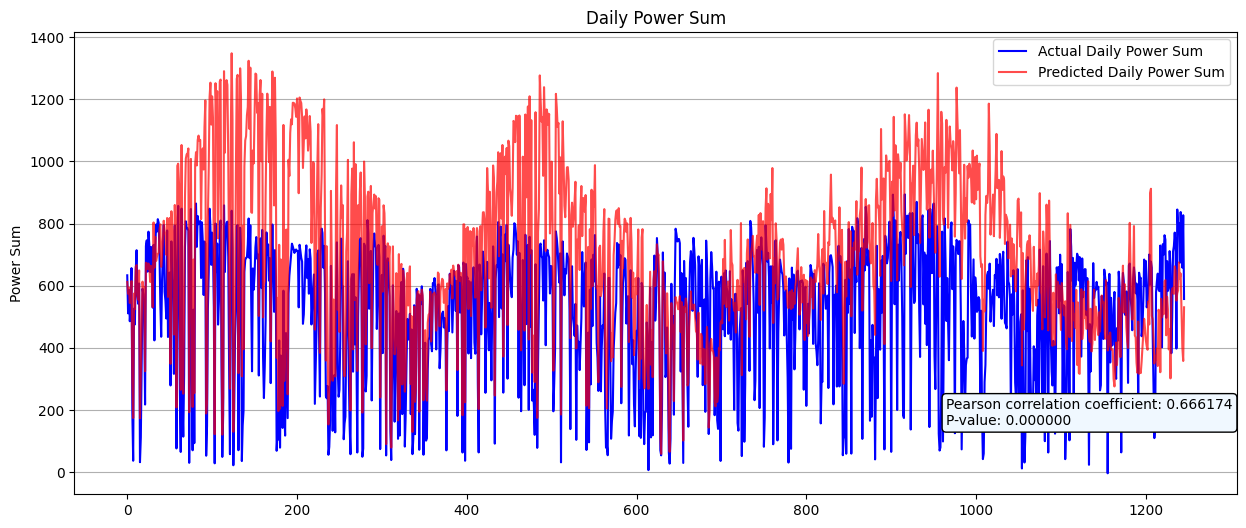

In [19]:
train = pd.read_csv('train_without_chenan.csv', encoding='cp949')
test = pd.read_csv('test_chenan.csv', encoding='cp949')
all_data = pd.concat([train, test], ignore_index=True)

all_data_train = all_data[all_data['location'] != 288.0] #밀양
all_data_test = all_data[all_data['location'] == 288.0]
 
daily_visualize(y_test, Regressor_pred, all_data_test)

In [20]:
X, y, X_test, y_test = preprocess_data()
rf_run = RandomForestRegressor()
rf_run.fit(X, y)
Regressor_pred_rf = rf_run.predict(X_test)
test_rmse(y_test, Regressor_pred_rf)

C:\Users\sedag\AppData\Local\Temp\ipykernel_24624\3376808835.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_train.fillna(-1, inplace=True)
C:\Users\sedag\AppData\Local\Temp\ipykernel_24624\3376808835.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_test.fillna(-1, inplace=True)


mae : 46.475991836553284
RMSE : 49.18015786802407
Normalized RMSE : 0.6508062087084536
Error Percentage : 0.001198056139709783


In [21]:
daily_visualize(y_test, Regressor_pred_rf, all_data_test)

ValueError: Shape of passed values is (13258, 1), indices imply (29449, 1)

# 천안 test set

In [14]:
X, y, X_test, y_test = preprocess_data()
ET_regressor = ExtraTreesRegressor()
ET_regressor.fit(X, y)
Regressor_pred = ET_regressor.predict(X_test)
test_rmse(y_test, Regressor_pred)

C:\Users\sedag\AppData\Local\Temp\ipykernel_24624\3376808835.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_train.fillna(-1, inplace=True)
C:\Users\sedag\AppData\Local\Temp\ipykernel_24624\3376808835.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_test.fillna(-1, inplace=True)


mae : 46.833640226026816
RMSE : 49.61279971351803
Normalized RMSE : 0.656531403815597
Error Percentage : 0.0012085955369333617


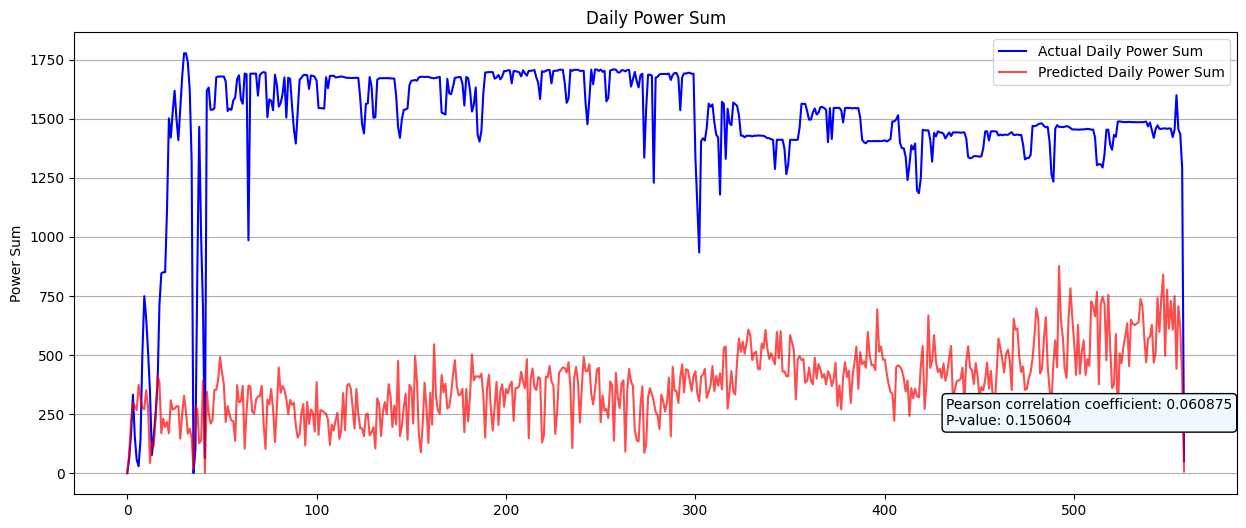

In [15]:
test = pd.read_csv('test_chenan.csv', encoding = 'cp949')
daily_visualize(y_test, Regressor_pred, test)

In [16]:
X, y, X_test, y_test = preprocess_data()
rf_run = RandomForestRegressor()
rf_run.fit(X, y)
Regressor_pred_rf = rf_run.predict(X_test)
test_rmse(y_test, Regressor_pred_rf)

C:\Users\sedag\AppData\Local\Temp\ipykernel_24624\3376808835.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_train.fillna(-1, inplace=True)
C:\Users\sedag\AppData\Local\Temp\ipykernel_24624\3376808835.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_test.fillna(-1, inplace=True)


mae : 46.47126686304085
RMSE : 49.17320627625533
Normalized RMSE : 0.6507142175624381
Error Percentage : 0.0011978867950480265


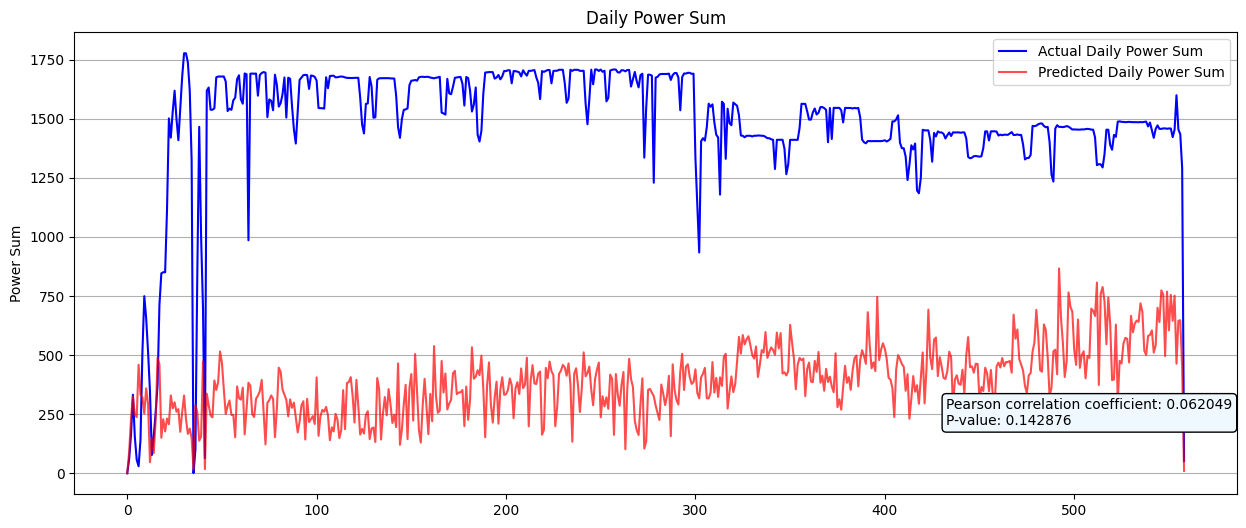

In [17]:
test = pd.read_csv('test_chenan.csv', encoding = 'cp949')
daily_visualize(y_test, Regressor_pred_rf, test)

# 영암 F1 데이터만 사용

In [15]:
X, y, X_test, y_test = preprocess_data()
ET_regressor = ExtraTreesRegressor()
ET_regressor.fit(X, y)
Regressor_pred = ET_regressor.predict(X_test)
test_rmse(y_test, Regressor_pred)

mae : 720.913924334005
RMSE : 4536.5111424703655
Normalized RMSE : 0.0003735598766856362
Error Percentage : 0.11051194755582895


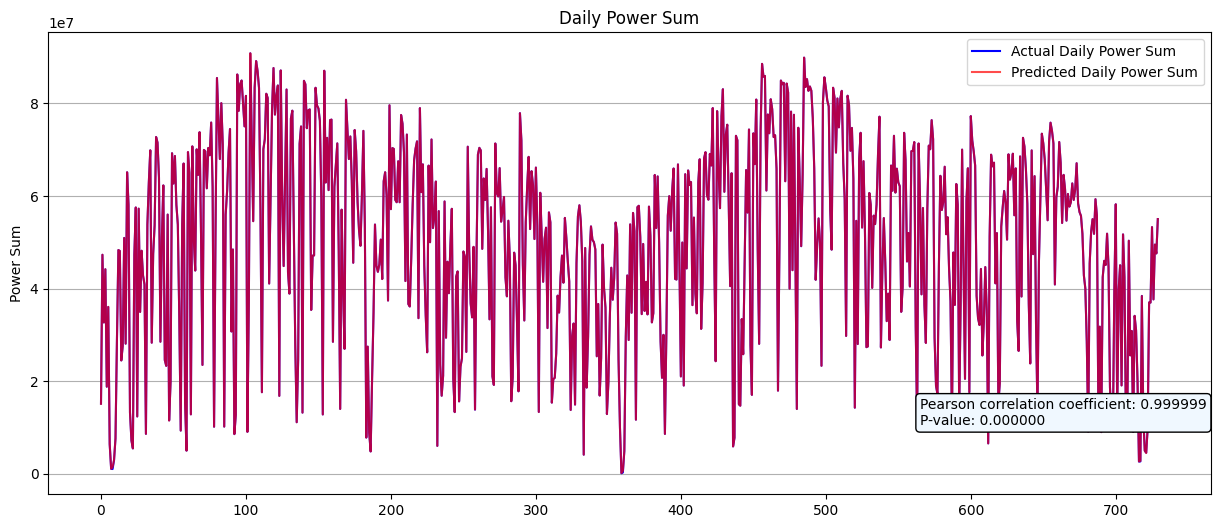

In [17]:
test = pd.read_csv('test_data_nan.csv', index_col='DateTime')
daily_visualize(y_test, Regressor_pred, test.index)

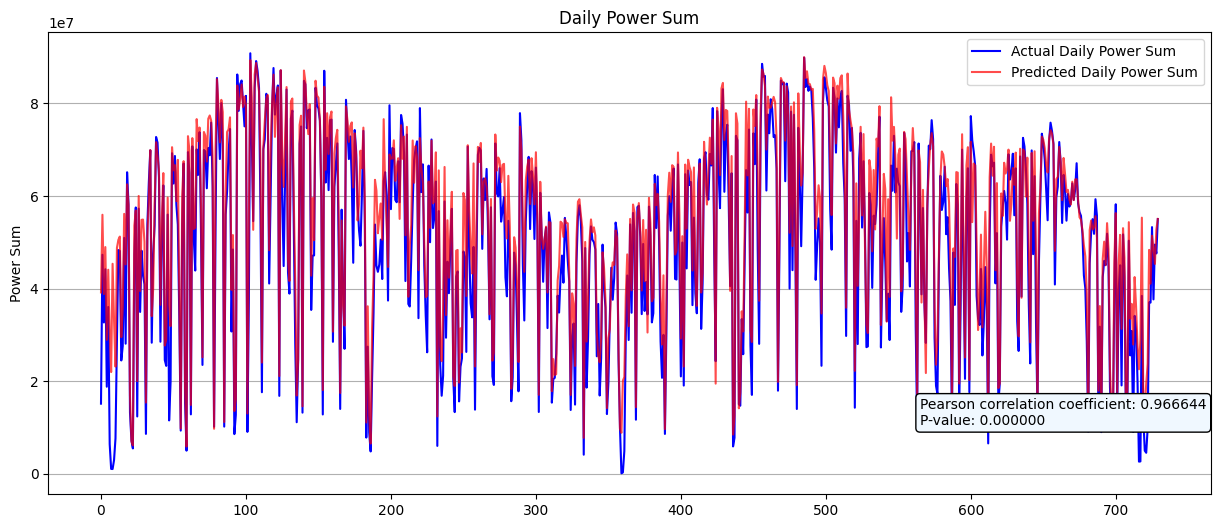

In [12]:
test = pd.read_csv('test_data_nan.csv', index_col='DateTime')
daily_visualize(y_test, Regressor_pred, test.index)

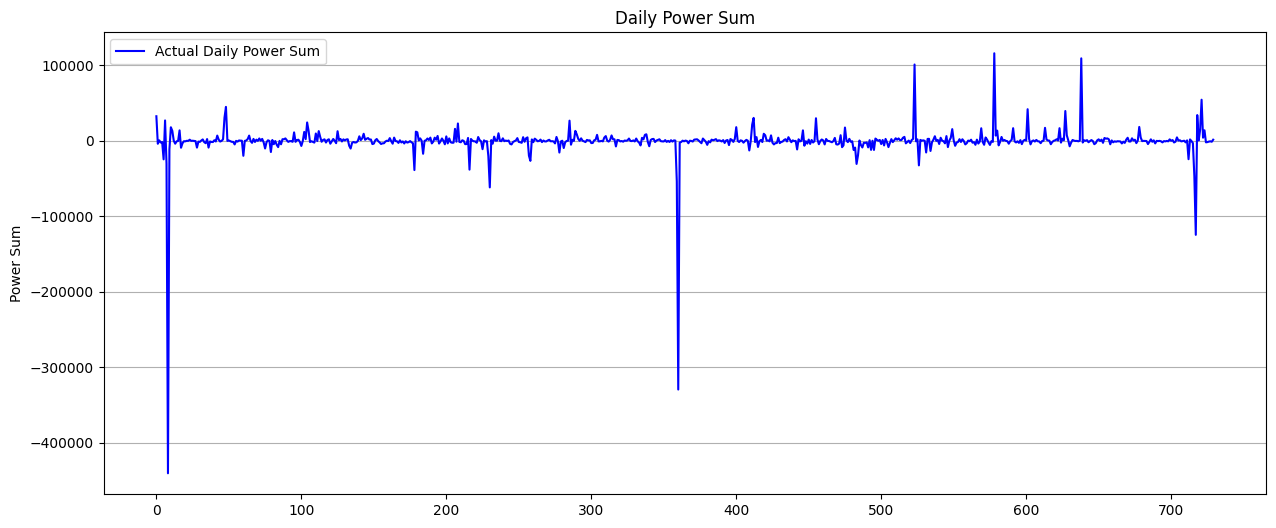

In [18]:
test = pd.read_csv('test_data_nan.csv', index_col='DateTime')

y_test_df = pd.DataFrame(y_test, index=pd.to_datetime(test.index), columns=['power'])

# 일자별로 그룹화하고 합계를 계산
daily_actual_sum = y_test_df.groupby(y_test_df.index.date)['power'].sum().values
daily_predicted_sum = [np.sum(Regressor_pred[y_test_df.index.date == date]) for date in np.unique(y_test_df.index.date)]

plt.figure(figsize=(15, 6))
plt.plot(daily_actual_sum - daily_predicted_sum, label='Actual Daily Power Sum', color='blue')
plt.title('Daily Power Sum')
plt.ylabel('Power Sum')
plt.legend()
plt.grid(True, axis='y')
plt.show()

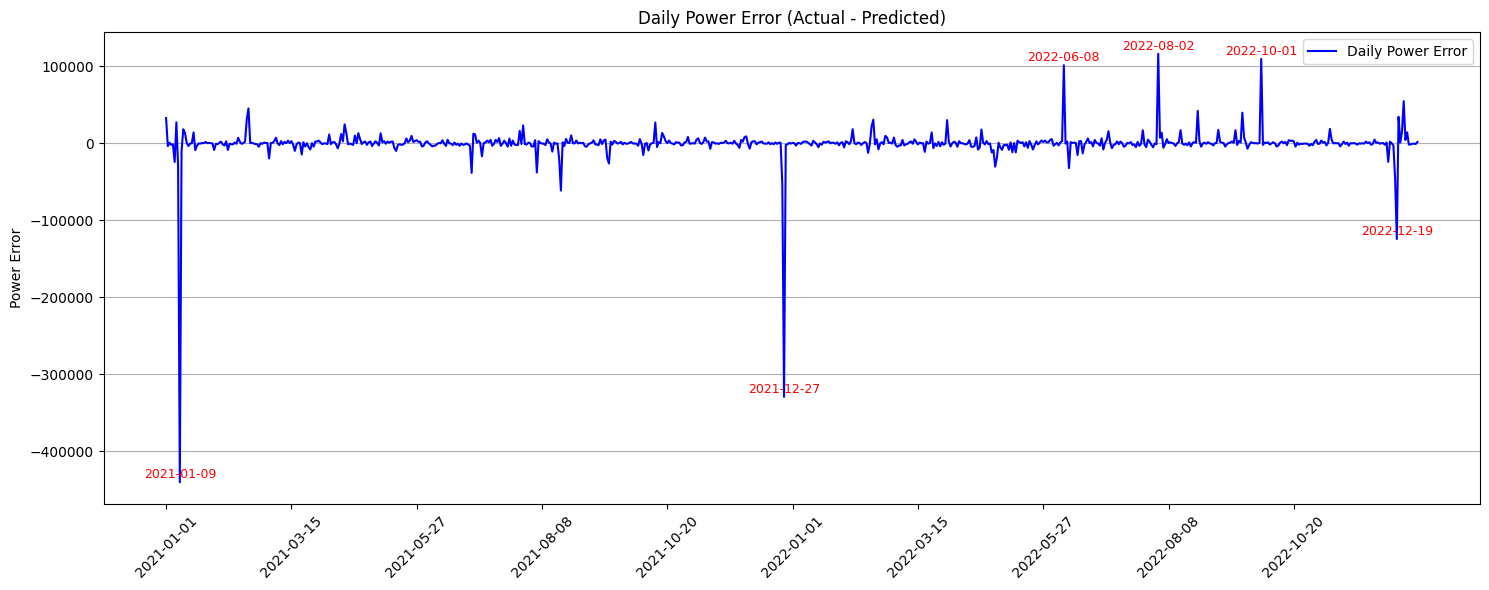

In [20]:

test = pd.read_csv('test_data_nan.csv', index_col='DateTime')

y_test_df = pd.DataFrame(y_test, index=pd.to_datetime(test.index), columns=['power'])

# 일자별로 그룹화하고 합계를 계산
daily_actual_sum = y_test_df.groupby(y_test_df.index.date)['power'].sum().values
daily_predicted_sum = [np.sum(Regressor_pred[y_test_df.index.date == date]) for date in np.unique(y_test_df.index.date)]

# 오차 계산
error = daily_actual_sum - daily_predicted_sum

# 오차와 관련된 날짜 정보를 데이터프레임으로 만들기
error_df = pd.DataFrame({
    'date': np.unique(y_test_df.index.date),
    'error': error
})

# 오차를 내림차순으로 정렬
sorted_error_df = error_df.sort_values(by='error', ascending=False)

# 상위 20개의 오차를 가진 날짜 선택
top_20_error_dates = sorted_error_df.head(6)

top_20_absolute_error_dates = error_df.iloc[np.argsort(-np.abs(error_df['error'].values))[:6]]


# 그래프 그리기
plt.figure(figsize=(15, 6))
plt.plot(error, label='Daily Power Error', color='blue')
plt.title('Daily Power Error (Actual - Predicted)')
plt.ylabel('Power Error')
plt.legend()
plt.grid(True, axis='y')

# x축에 날짜 정보 설정
dates = np.unique(y_test_df.index.date)
plt.xticks(ticks=range(0, len(dates), int(len(dates)/10)), labels=[dates[i].strftime('%Y-%m-%d') for i in range(0, len(dates), int(len(dates)/10))], rotation=45)

# 상위 20개 오차를 그래프에 주석으로 추가
for idx, row in top_20_absolute_error_dates.iterrows():
    date = row['date']
    err = row['error']
    date_idx = list(dates).index(date)
    plt.annotate(f"{date.strftime('%Y-%m-%d')}", (date_idx, err), 
                 textcoords="offset points", xytext=(0,3), ha='center', fontsize=9, color='red')

plt.tight_layout()
plt.show()

In [22]:
X, y, X_test, y_test = preprocess_data()
rf_run = RandomForestRegressor()
rf_run.fit(X, y)
Regressor_pred_rf = rf_run.predict(X_test)
test_rmse(y_test, Regressor_pred_rf)

mae : 18.917170360420865
RMSE : 390.7504595616469
Normalized RMSE : 3.217642124190109e-05
Error Percentage : 0.009518899642992526


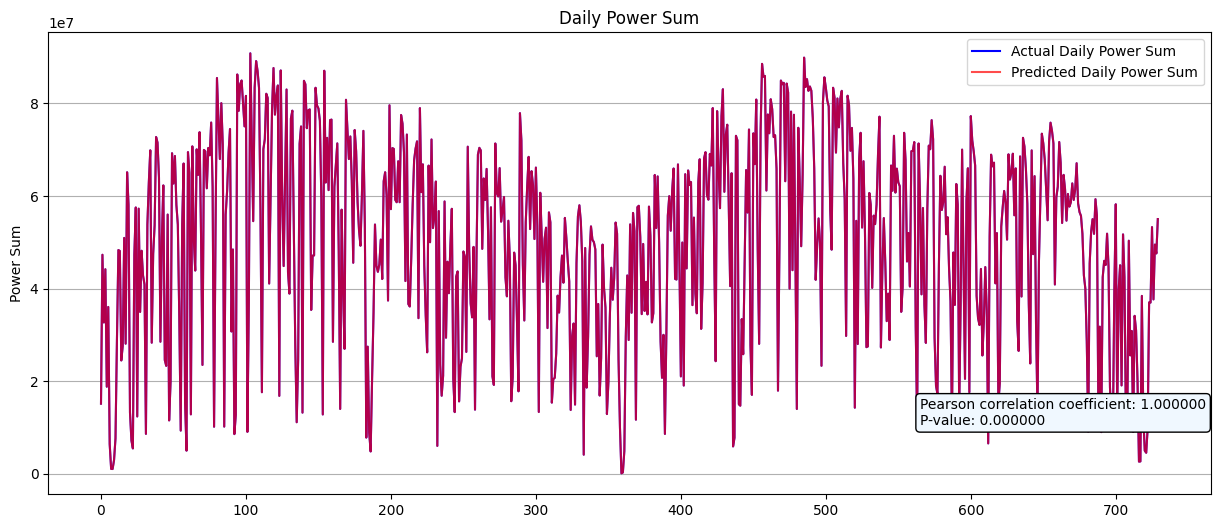

In [24]:
test = pd.read_csv('test_data_nan.csv', index_col='DateTime')
daily_visualize(y_test, Regressor_pred_rf, test.index)

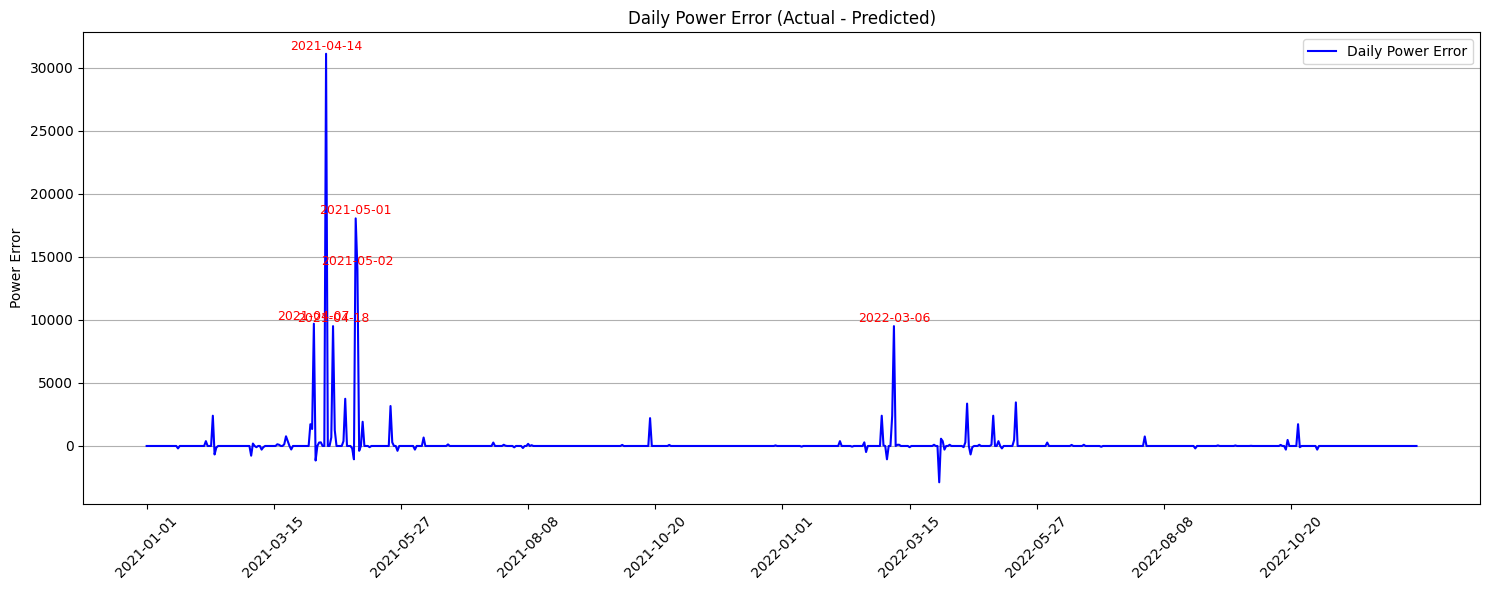

In [25]:

test = pd.read_csv('test_data_nan.csv', index_col='DateTime')

y_test_df = pd.DataFrame(y_test, index=pd.to_datetime(test.index), columns=['power'])

# 일자별로 그룹화하고 합계를 계산
daily_actual_sum = y_test_df.groupby(y_test_df.index.date)['power'].sum().values
daily_predicted_sum = [np.sum(Regressor_pred_rf[y_test_df.index.date == date]) for date in np.unique(y_test_df.index.date)]

# 오차 계산
error = daily_actual_sum - daily_predicted_sum

# 오차와 관련된 날짜 정보를 데이터프레임으로 만들기
error_df = pd.DataFrame({
    'date': np.unique(y_test_df.index.date),
    'error': error
})

# 오차를 내림차순으로 정렬
sorted_error_df = error_df.sort_values(by='error', ascending=False)

# 상위 20개의 오차를 가진 날짜 선택
top_20_error_dates = sorted_error_df.head(6)

top_20_absolute_error_dates = error_df.iloc[np.argsort(-np.abs(error_df['error'].values))[:6]]


# 그래프 그리기
plt.figure(figsize=(15, 6))
plt.plot(error, label='Daily Power Error', color='blue')
plt.title('Daily Power Error (Actual - Predicted)')
plt.ylabel('Power Error')
plt.legend()
plt.grid(True, axis='y')

# x축에 날짜 정보 설정
dates = np.unique(y_test_df.index.date)
plt.xticks(ticks=range(0, len(dates), int(len(dates)/10)), labels=[dates[i].strftime('%Y-%m-%d') for i in range(0, len(dates), int(len(dates)/10))], rotation=45)

# 상위 20개 오차를 그래프에 주석으로 추가
for idx, row in top_20_absolute_error_dates.iterrows():
    date = row['date']
    err = row['error']
    date_idx = list(dates).index(date)
    plt.annotate(f"{date.strftime('%Y-%m-%d')}", (date_idx, err), 
                 textcoords="offset points", xytext=(0,3), ha='center', fontsize=9, color='red')

plt.tight_layout()
plt.show()

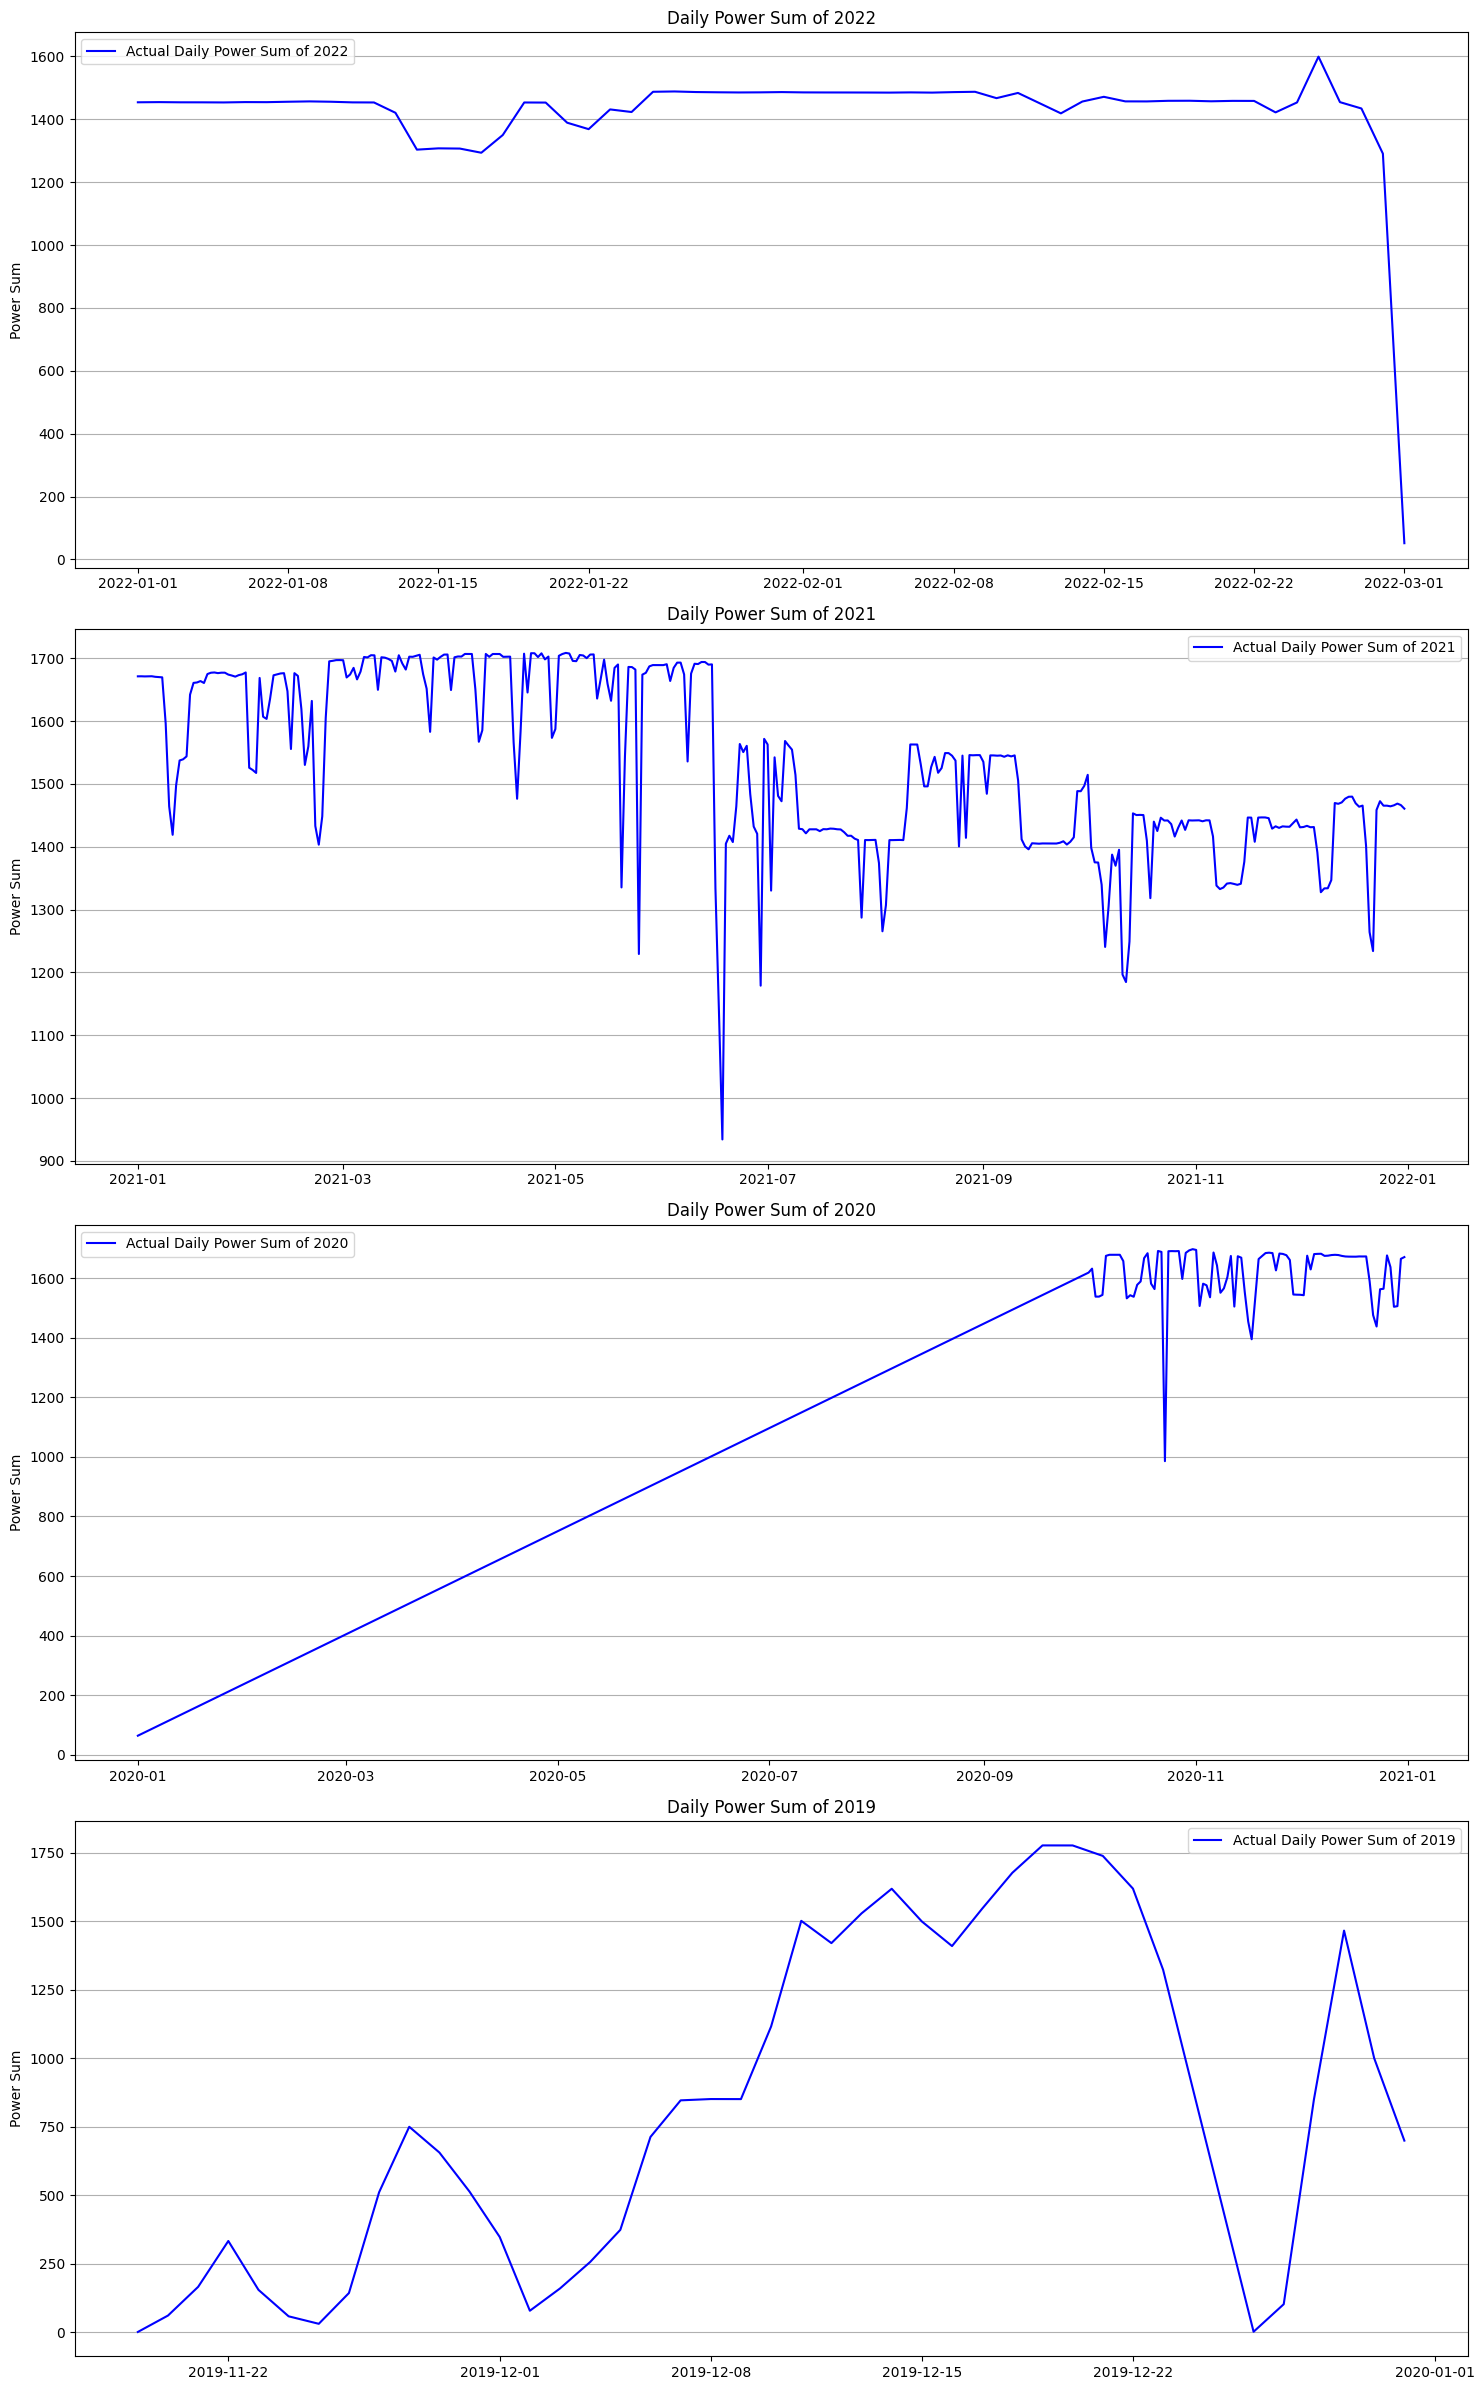

In [4]:
train = pd.read_csv('train_without_chenan.csv', encoding='cp949')
test = pd.read_csv('test_chenan.csv', encoding='cp949')
train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)
all_data = pd.concat([train, test], ignore_index=True)

all_data['date'] = pd.to_datetime(all_data['date'])

# 연도, 월, 시간 추출하여 새로운 열로 추가
all_data['year'] = all_data['date'].dt.year
all_data['month'] = all_data['date'].dt.month
all_data['hour'] = all_data['date'].dt.hour


drop_columns = ["date", "asos_num", "location", "name"]

all_data = all_data.drop(columns=drop_columns)

all_data.head()
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data)], format='csr')
num_train = len(train)
X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]
y = train['power/land'].values
y_test = test['power/land'].values

# 'date' 칼럼을 datetime 형식으로 변환하고 인덱스로 설정
y_test_df = pd.DataFrame(y_test, index=pd.to_datetime(test['date']), columns=['power/land'])

unique_years = y_test_df.index.year.unique()

plt.figure(figsize=(15, 6 * len(unique_years)))

for idx, year in enumerate(unique_years):
    yearly_data = y_test_df[y_test_df.index.year == year]
    
    # 일자별로 그룹화하고 합계를 계산
    daily_actual_sum = yearly_data.groupby(yearly_data.index.date)['power/land'].sum()
    
    plt.subplot(len(unique_years), 1, idx+1)
    plt.plot(daily_actual_sum, label=f'Actual Daily Power Sum of {year}', color='blue')
    plt.title(f'Daily Power Sum of {year}')
    plt.ylabel('Power Sum')
    plt.legend()
    plt.grid(True, axis='y')

plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
all_data = pd.read_csv('asos_train.csv', encoding='cp949')
all_data.head()

,power,date,name,capacities,asos_num,land,power/land,location,Date/Time,Temp(C),Prec(mm),Wind_speed(m/s),Wind_Direction(16 compass points),Humidity,Vapor_pressure(hPa),Dew_Point(C),Local Atmospheric Pressure(hPa),Sea-level_Pressure(hPa),sunshine(hr),Solar_Radiation(MJ/m2),Snowfall(cm),3-hour_Fresh_Snowfall,Cloud_Cover(1/10),Mid-Low_Cloud_Cover,Cloud_Form,Lowest_Cloud_Height(100m),Visibility(10m),Ground_Condition,Phenomenon_Number,Ground Temp,5cm_Underground_Temp,10cm_Underground_Temp,20cm_Underground_Temp,30cm_Underground_Temp
0,1296000.0,2022-12-31 09:00:00,영암에프원태양광b,13.296,165.0,175507.2,7.384312,165.0,2022-12-31 09:00:00,0.1,NaN,0.9,70.0,85.0,5.2,-2.1,1027.7,1033.4,0.7,0.37,NaN,NaN,0.0,0.0,NaN,NaN,1295.0,NaN,NaN,-0.5,2.5,3.3,4.2,4.7
1,4377600.0,2022-12-31 10:00:00,영암에프원태양광b,13.296,165.0,175507.2,24.942566,165.0,2022-12-31 10:00:00,1.7,NaN,0.4,0.0,75.0,5.2,-2.2,1028.0,1033.7,1.0,1.04,NaN,NaN,0.0,0.0,NaN,NaN,1534.0,NaN,NaN,0.0,2.9,3.4,4.2,4.8
2,7065600.0,2022-12-31 11:00:00,영암에프원태양광b,13.296,165.0,175507.2,40.258177,165.0,2022-12-31 11:00:00,2.8,NaN,2.4,50.0,64.0,4.8,-3.3,1027.7,1033.4,1.0,1.54,NaN,NaN,0.0,0.0,NaN,NaN,2617.0,NaN,NaN,3.8,3.7,3.7,4.2,4.8
3,8860800.0,2022-12-31 12:00:00,영암에프원태양광b,13.296,165.0,175507.2,50.486818,165.0,2022-12-31 12:00:00,4.1,NaN,3.8,360.0,61.0,5.0,-2.7,1027.0,1032.6,1.0,1.86,NaN,NaN,0.0,0.0,NaN,NaN,2779.0,NaN,NaN,10.3,4.4,3.9,4.2,4.8
4,7891200.0,2022-12-31 13:00:00,영암에프원태양광b,13.296,165.0,175507.2,44.962258,165.0,2022-12-31 13:00:00,4.2,NaN,5.4,340.0,57.0,4.7,-3.5,1026.2,1031.8,0.6,1.53,NaN,NaN,4.0,4.0,Sc,10.0,3442.0,NaN,NaN,6.1,4.7,4.3,4.3,4.7


In [9]:
all_data['location'].unique()

array([165., 112., 140., 133., 288., 239., 119., 260., 232.])

In [11]:
X_test.shape

(29449, 12)